In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [78]:
image_style = Image.open('/content/style (2).jpg').convert('RGB')
image_content = Image.open('/content/content.jpg').convert('RGB')

In [79]:
def convert_image(image):
    in_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:]
    return image

In [80]:
image_style = convert_image(image_style).to(device)
image_content = convert_image(image_content).to(device
                                              )

In [81]:
image_content.shape, image_style.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


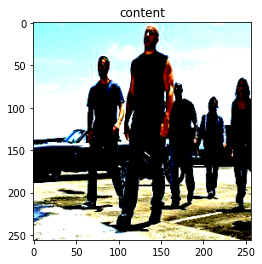

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


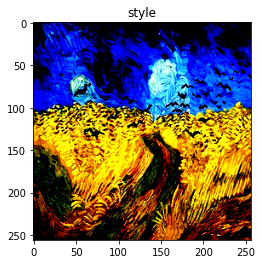

In [82]:
plt.imshow(image_content.permute(1,2, 0).cpu())
plt.title("content")
plt.show();

plt.imshow(image_style.permute(1,2,0).cpu())
plt.title("style")
plt.show();

In [83]:
def inversed_converting(img):
    image = img.permute(1,2,0)
    image = image * torch.Tensor((0.229, 0.224, 0.225)).to(device) + torch.Tensor((0.485, 0.456, 0.406)).to(device)
    image = image.clip(0, 1)

    return image

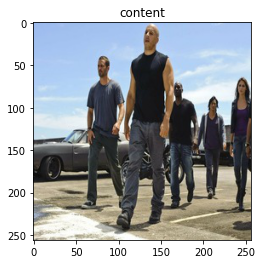

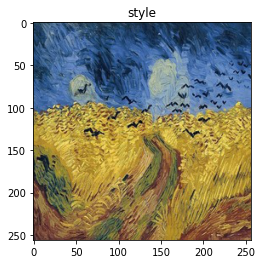

In [84]:
plt.imshow(inversed_converting(image_content).cpu())
plt.title("content")
plt.show();

plt.imshow(inversed_converting(image_style).cpu())
plt.title("style")
plt.show();

In [85]:
from torchvision.models import vgg19

model = models.vgg19(pretrained=True).features.to(device)
for param in model.parameters():
    param.requires_grad_(False)

In [86]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [87]:
def Gramm(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

In [88]:
def conv_features(model, image):
    answer = {}
    cur = image
    for name, layer in model._modules.items():
        cur = layer(cur)
        if isinstance(layer, nn.Conv2d):
            answer[str(name)] = cur
    return answer

In [89]:
batch_image_content = image_content.unsqueeze(0).to(device)
batch_image_style = image_style.unsqueeze(0).to(device)

features_content = conv_features(model, batch_image_content)
features_image_style = conv_features(model, batch_image_style)

In [90]:
style_grams = {layer: Gramm(features_image_style[layer]) for layer in features_image_style.keys()}


In [91]:
def content_loss(content, target):
    return torch.mean((target - content) ** 2)



In [ ]:
target = image_content.clone().requires_grad_(True).to(device)

optimizer = torch.optim.Adam([target], lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Loss in epoch 1 : 1376242.125


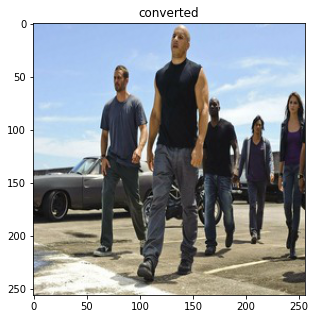

Loss in epoch 501 : 152105.53125


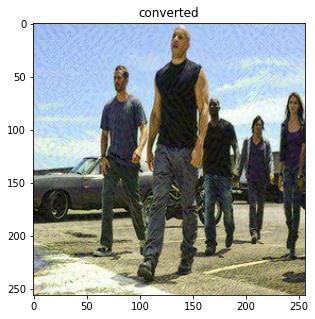

Loss in epoch 1001 : 80563.8046875


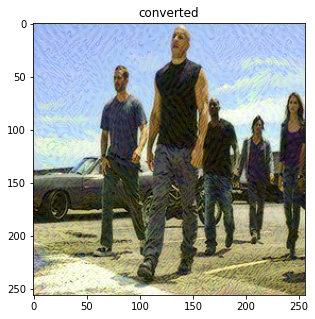

Loss in epoch 1501 : 51871.38671875


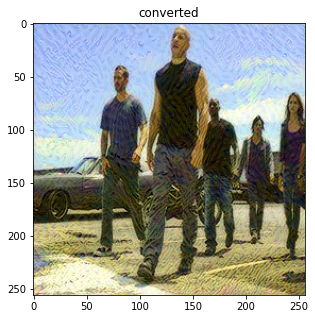

Loss in epoch 2001 : 36996.53125


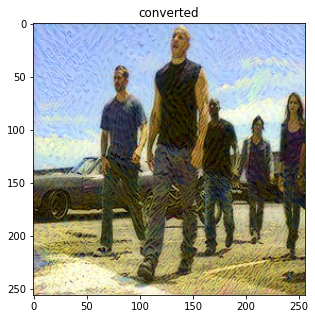

Loss in epoch 2501 : 28293.8828125


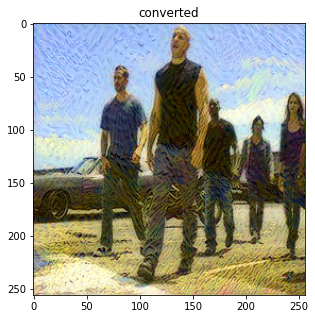

Loss in epoch 3001 : 22693.125


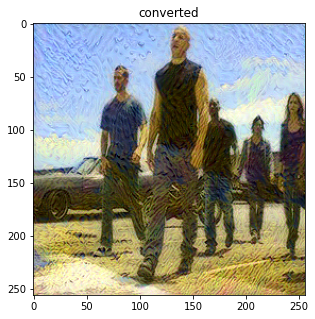

Loss in epoch 3501 : 18708.35546875


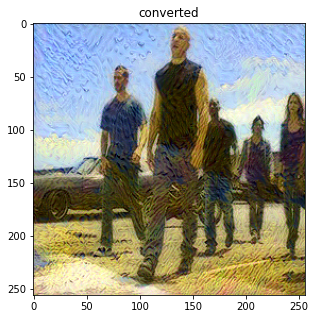

Loss in epoch 4001 : 15601.85546875


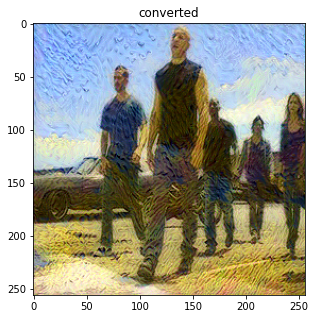

Loss in epoch 4501 : 13031.0595703125


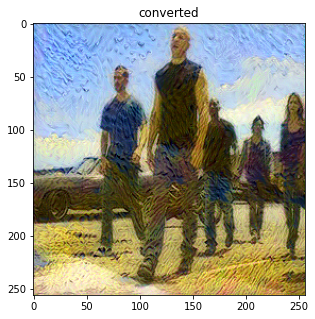

Loss in epoch 5001 : 10855.59375


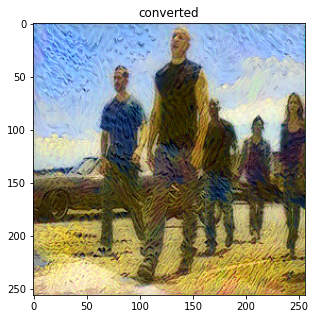

Loss in epoch 5501 : 9006.0205078125


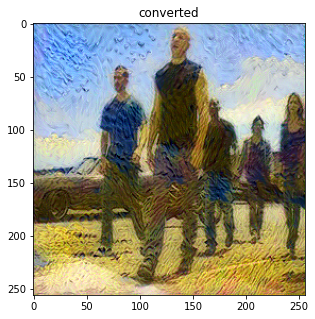

Loss in epoch 6001 : 7454.11669921875


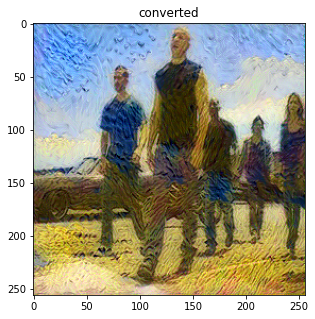

Loss in epoch 6501 : 6166.60546875


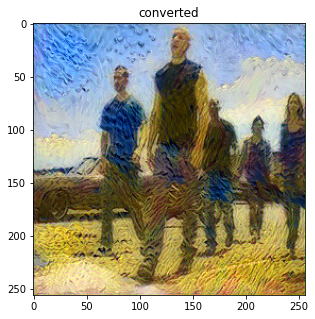

Loss in epoch 7001 : 5127.7109375


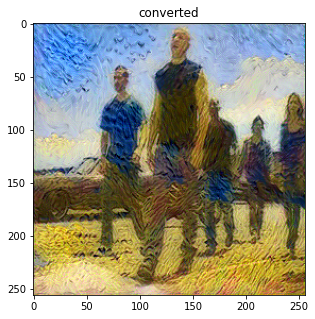

Loss in epoch 7501 : 4311.58740234375


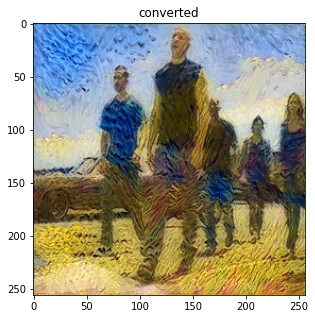

Loss in epoch 8001 : 3672.58935546875


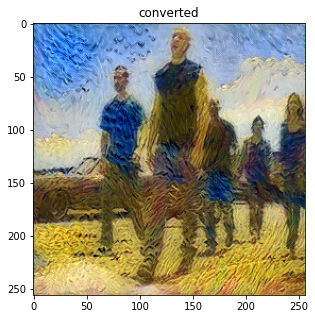

Loss in epoch 8501 : 3171.65380859375


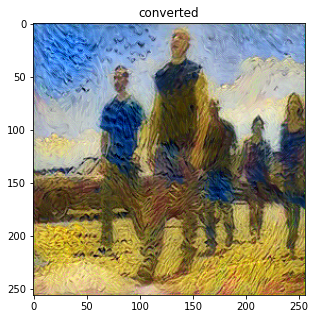

Loss in epoch 9001 : 2772.9033203125


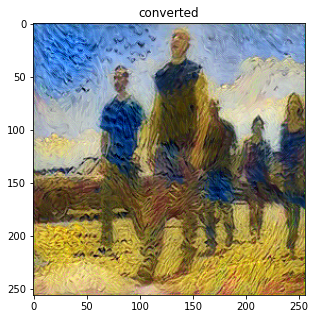

Loss in epoch 9501 : 2446.9404296875


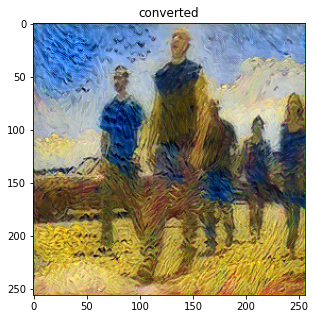

In [94]:
from tqdm.auto import tqdm

losses = []


num_epochs = 10000
for epoch in tqdm(range(num_epochs)):
    target_features = conv_features(model, target.unsqueeze(0))
    loss_content = content_loss(features_content['34'], target_features['34'])
    loss_style = 0
    
    for name_layer in features_content.keys():
        matrix_gram_target = Gramm(target_features[name_layer])
        matrix_gram_style = style_grams[name_layer]
        _, d, h, w = target_features[name_layer].shape

        loss_style += content_loss(matrix_gram_style, matrix_gram_target) / (d * w * h)

    loss = loss_content + 1000 * loss_style
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Loss in epoch {epoch + 1} : {loss.item()}")
        fig = plt.figure(figsize = (5, 5))
        plt.imshow(inversed_converting(target).cpu().detach().numpy())
        plt.title("converted")
        plt.show();

Text(0.5, 1.0, 'Loss per epochs')

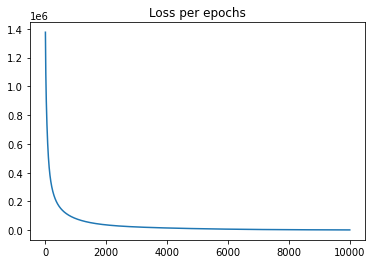

In [96]:
import numpy as np
plt.plot(np.arange(len(losses)), losses)
plt.title("Loss per epochs")